- Here is some code that suppresses warning messages.

In [3]:
from transformers.utils import logging
logging.set_verbosity_error()

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

In [4]:
from transformers import pipeline

In [ ]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

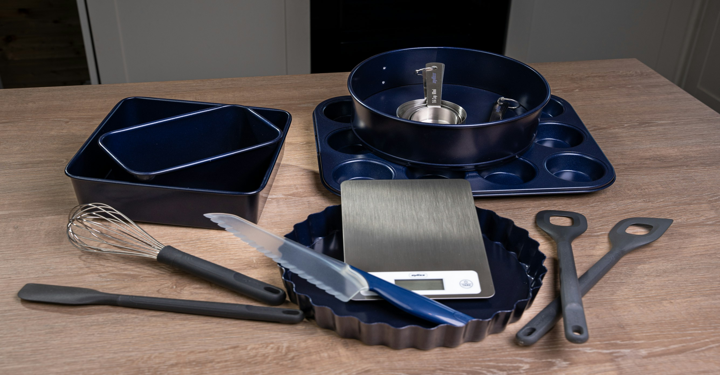

In [7]:
from PIL import Image
import requests

img_url = 'https://images.unsplash.com/photo-1725524089635-4c4e35b19ada?q=80&w=2670&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'

raw_image =  Image.open(
    requests.get(img_url, stream=True).raw).convert('RGB')
raw_image.resize((720, 375))

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference will be

In [8]:
output = sam_pipe(raw_image, points_per_batch=32)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

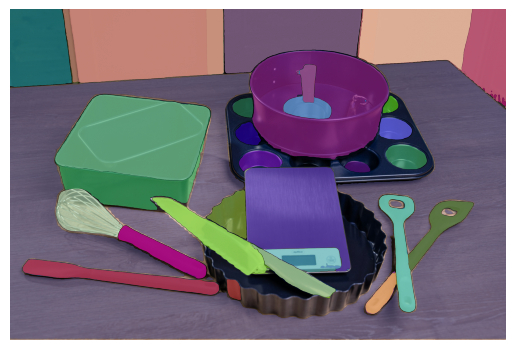

In [10]:
show_pipe_masks_on_image(raw_image, output)

### Faster Inference: Infer an Image and a Single Point

In [11]:
from transformers import SamModel, SamProcessor

In [12]:
model = SamModel.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

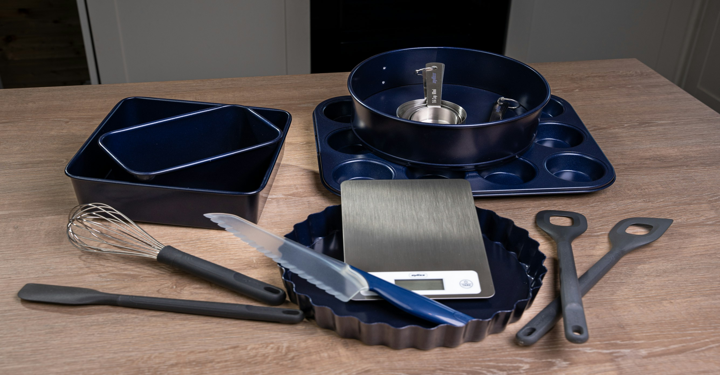

In [13]:
raw_image.resize((720, 375))

In [14]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [15]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

- Given the inputs, get the output from the model.

In [16]:
import torch

In [17]:
with torch.no_grad():
    outputs = model(**inputs)

In [18]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [19]:
len(predicted_masks)

1

- Inspect the size of the first ([0]) predicted mask

In [20]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 1780, 2670])

In [21]:
outputs.iou_scores

tensor([[[0.8195, 0.9564, 0.8796]]])

In [22]:
from helper import show_mask_on_image

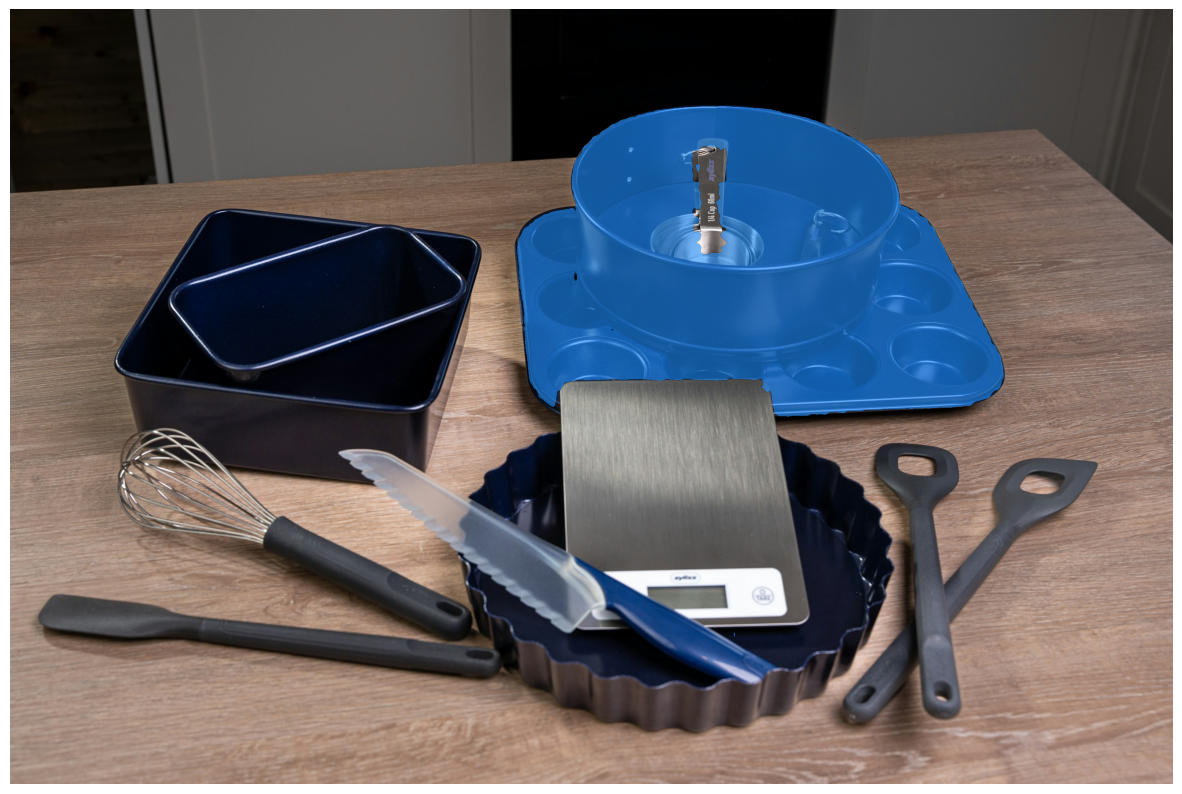

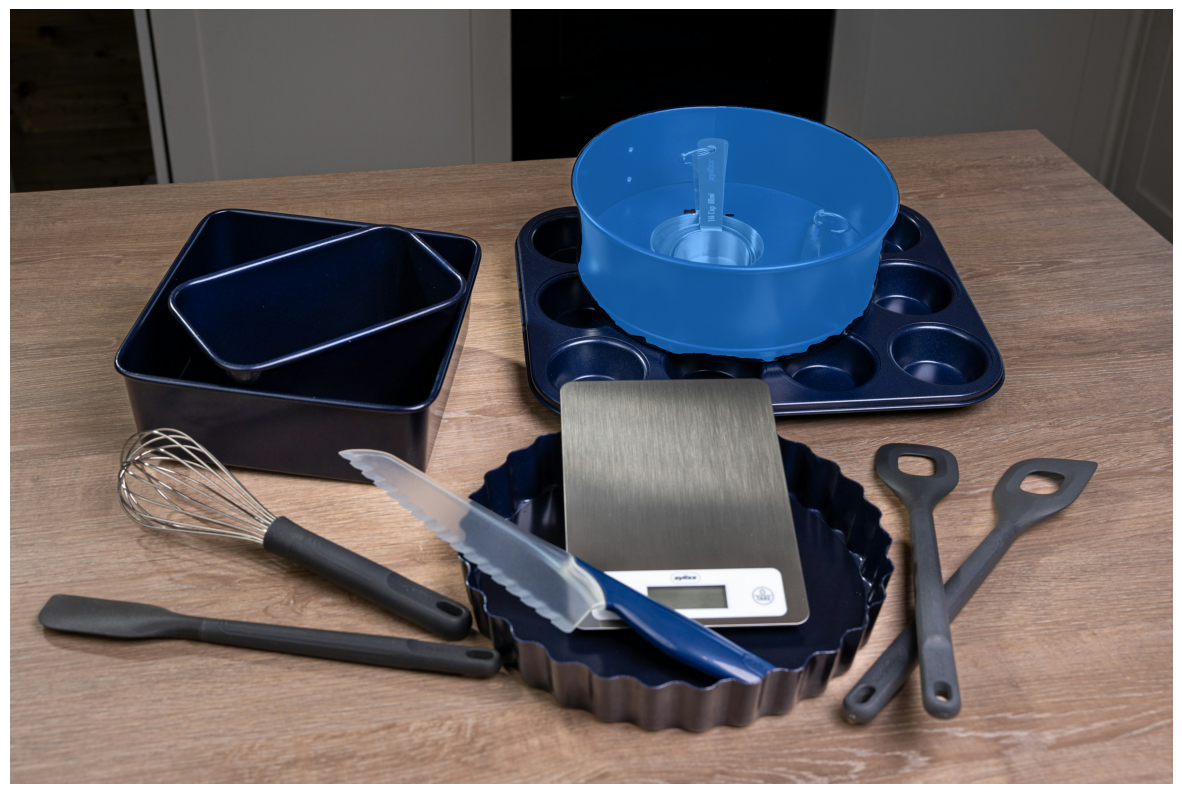

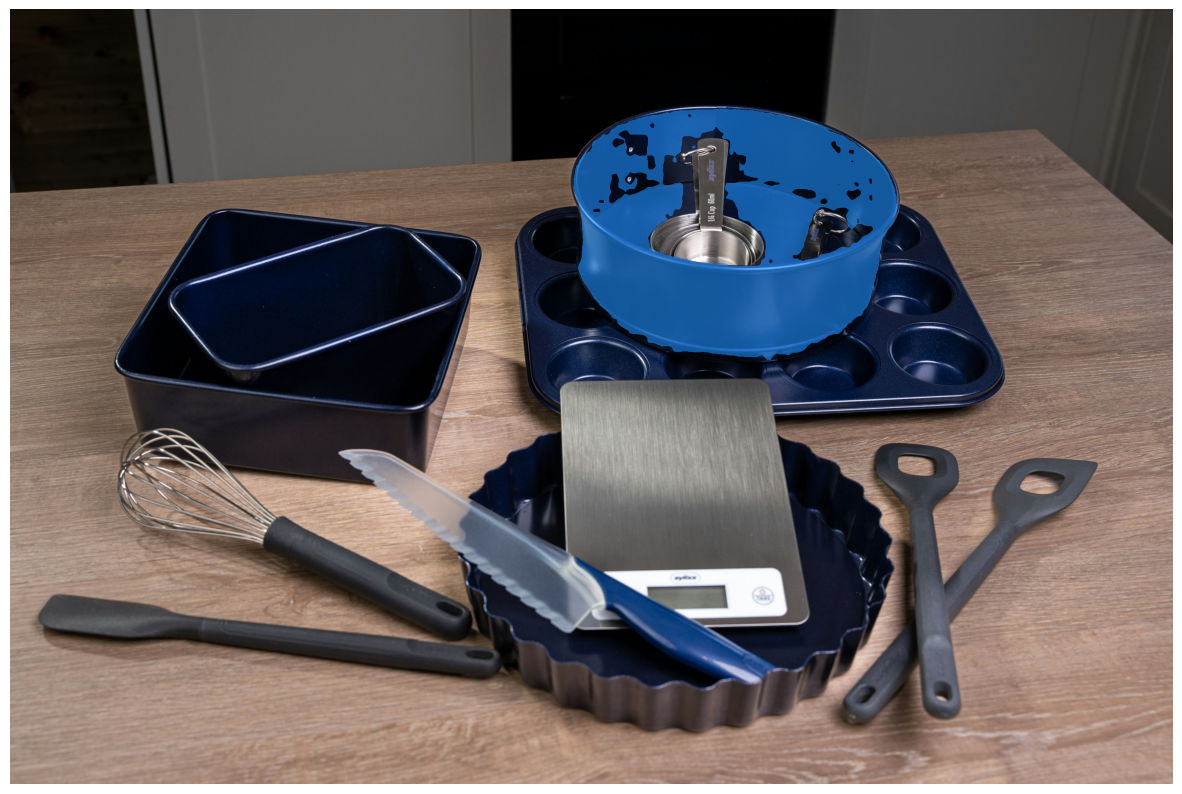

In [23]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])